In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json 
from sklearn.metrics import roc_curve

In [2]:
INPUT_PATH = "ratings.json"

In [3]:
ratings_dict = json.load(open(INPUT_PATH))
ratings = ratings_dict["ratings_merged"]
probabilities = ratings_dict["probabilities"]

In [4]:
X = np.array(probabilities).reshape(-1, 1)
y = np.array(ratings)

### Threshold detection using changepoint model

In [ ]:
xs = X.ravel()
ys = y.ravel()

candidates = np.unique(xs)
losses = []

for t in candidates:
    pred = (xs >= t).astype(int)
    losses.append(np.mean(pred != ys))

threshold = candidates[np.argmin(losses)]

print(f"Optimal threshold using Change-Point or Threshold model: {threshold:.4f} with loss {min(losses):.4f}")

Optimal threshold using Change-Point or Threshold model (GPT-suggestion, needs some theoretical understanding): 0.2542 with loss 0.1400


Optimal threshold using ROC curve: 0.3300


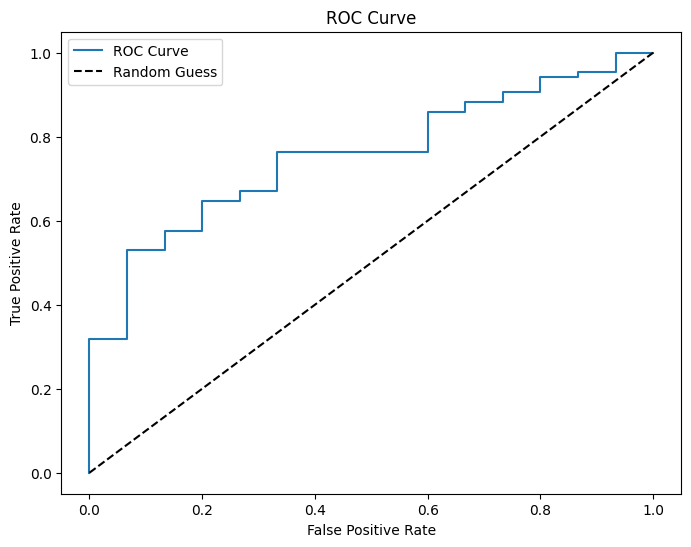

In [6]:
fpr, tpr, thresholds = roc_curve(y, X)
best = np.argmax(tpr - fpr)
threshold = thresholds[best]
print(f"Optimal threshold using ROC curve: {threshold:.4f}")
# plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, X)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Outdated: Process disagreements

In [ ]:
# disagreements = np.array([np.abs(r1 - r2) for r1, r2 in zip(ratings, ratings_quirin)])
# new_ratings = dict()

# for sample_index, r in sampled[disagreements == 1].iterrows():
#     # sample_index = int(disagreements_indices[i][0])
    
#     print(sample_index, r[prob_col])
#     print("jakob:", ratings[sample_index])
#     print("quirin:", ratings_quirin[sample_index])

#     print(textwrap.fill(r["translatedText"], width=90))
#     print("="*100)
#     response = process_response("q to quit, y/n to continue")
#     if response == -1: 
#         break 
#     new_ratings[sample_index] = response
#     clear_output()

# ratings_merged = ratings.copy()
# for i, new_rating in new_ratings.items():
#     ratings_merged[int(i)] = new_rating

# # save ratings merged to json
# ratings_dict["ratings_merged"] = ratings_merged
# with open(INPUT_PATH, 'w') as f:
#     json.dump(ratings_dict, f)
# print(f"Saved merged ratings to {INPUT_PATH}")

### Outdated: Use logistic regression

Average correct topic rate: 0.88
(50, 1) (100, 1)
Topic probability threshold for 95.0% accuracy: 0.831955686386226


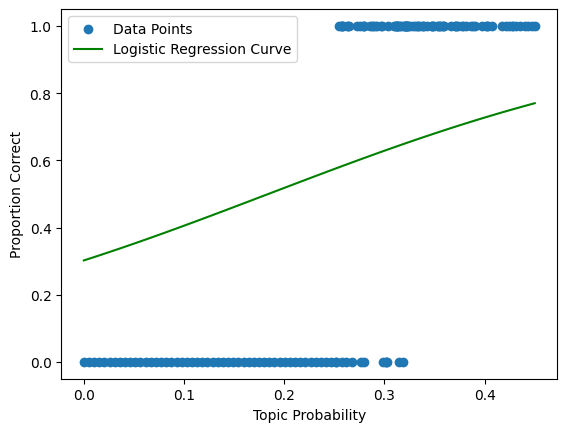

In [ ]:
# from sklearn.linear_model import LogisticRegression

# for df_ratings in ratings_both:
#     # print average rejection rate
#     avg_correct = df_ratings['rating'].mean()
#     print(f"Average correct topic rate: {avg_correct:.2f}")
#     # calculate mean ratings for every whole percentage step
#     stepsize = 0.02
#     # percentile_segments = np.arange(prob_range[0], prob_range[1] + 1, stepsize)
#     # segment_n = len(percentile_segments)
#     # proportion_correct = []
#     # for i in range(len(percentile_segments)):
#     #     if i == segment_n-1:
#     #         upper_bound = percentile_segments[-1]
#     #     else:
#     #         lower_bound = percentile_segments[i]
#     #         upper_bound = percentile_segments[i+1]
#     #         segment_ratings = df_ratings[(df_ratings[f'topic_{topic_id}'] >= lower_bound) & (df_ratings[f'topic_{topic_id}'] < upper_bound)]
#     #         if len(segment_ratings) > 0:
#     #             prop_correct = segment_ratings['rating'].mean()
#     #         else:
#     #             prop_correct = np.nan
#     #     proportion_correct.append(prop_correct)

#     # fit logistic regression model
#     # rating as categorical variable
#     df_ratings['rating'] = df_ratings['rating'].astype(int)
#     X = np.array(df_ratings[f'topic_{topic_id}']).reshape(-1, 1)
#     y = np.array(df_ratings["rating"]).reshape(-1, 1)
    
#     X_sim = np.linspace(0, X.min(), num=50).reshape(-1, 1)
#     y_sim = np.zeros(X_sim.shape)

#     print(X_sim.shape, X.shape)

#     X_merged = np.concat((X_sim, X))
#     y_merged = np.concat((y_sim, y))


#     log_model = LogisticRegression()
#     log_model.fit(X_merged, y_merged.ravel())
#     desired_accuracy = 0.95

#     # plot logistic regression curve
#     plt.figure()
#     plt.scatter(X_merged, y_merged, label='Data Points')
#     # Generate a range of percentiles for smooth curve
#     x_range = np.linspace(X_merged.min(), X_merged.max()).reshape(-1, 1)
#     # Predict probabilities using the logistic model
#     y_prob = log_model.predict_proba(x_range)[:, 1]
#     plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')

#     # Calculate the percentile threshold for the desired accuracy
#     logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
#     coef = log_model.coef_[0][0]
#     intercept = log_model.intercept_[0]
#     percentile_threshold = (logit_threshold - intercept) / coef
#     print(f"Topic probability threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")

#     # plt.axhline(desired_accuracy, linestyle="--")
#     # plt.axvline(percentile_threshold, linestyle="-", c="red")
#     plt.xlabel('Topic Probability')
#     plt.ylabel('Proportion Correct')
#     plt.legend()
#     plt.show()

